In [254]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
import numpy as np
import tensorflow as tf
import time
import pickle

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 4*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

from tensorflow.math import sin, cos, tan
import tensorflow_probability as tfp
import sys
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
from ICET_spherical import ICET
from utils import *
from metpy.calc import lat_lon_grid_deltas
from pioneer.das.api.platform import Platform
from scipy.spatial.transform import Rotation as R
from pioneer.das.api.egomotion.imu_egomotion_provider import IMUEgomotionProvider as emp 
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 180 seconds


# Goal: Simultaneously Estimate Translation, Rotation, and Distortion

## $\mathbf{A} = [\hat{X}_{ij}, \hat{m}_{ij}] = 
\begin{bmatrix}
% x, ~ y, ~ z, ~ \phi, ~ \theta, ~ \psi, ~ x^+, ~y^+, ~z^+, ~\phi^+, ~\theta^+, ~\psi^+ \\
x, ~ y, ~ z, ~ \phi, ~ \theta, ~ \psi, ~ x^+, ~y^+, ~z^+, ~\phi^+, ~\theta^+, ~\psi^+ \\
\end{bmatrix}$

We can use newton-raphson to find A

<!-- ## $y_i = \mathbf{h}(y_j, \hat{X}_{ij}, \hat{m}_{ij}) + \mathbf{H}_m \delta m + \mathbf{H}_x \delta x + \text{H.O.T.}$ -->

## $y_i = \mathbf{h}(y_j, \hat{A}_{ij}) + \mathbf{H}_A \delta A + \text{H.O.T.}$

## $\mathbf{H}_A \in \mathbb{R}^{4N \times 12} $



### $\mathbf{H}_A = [H_X, H_m]$

# Problem:  what if distortion correction and rigid transform both work equally well?

(ex: there are not enough features on one side to completely enclose the vehicle)

### IT MAKES LIFE WAY EASIER IF I SUPPRESS ANGULAR COMPONENT OF MOTION PROFILE??

### Run Demo

In [3]:
# load point cloud
# # no distortion
# old_cloud =  np.load("sample_data/paper_figures/case1/raw_frame_0.npy")
# # m_hat = np.array([0., 0., 0., 0., 0., 0.0]) #actual motion
# m_hat = np.array([-3., 0., 0., 0., 0., 0.1]) #test wrap around

# movement in x
old_cloud =  np.load("sample_data/paper_figures/case2/raw_frame_3.npy") 
# m_hat = np.array([3, 0, 0., 0., 0., 0])
m_hat = np.array([3., 0, 0., 0., 0., -0.2]) #FOR DEBUG-- deform just a little
gt =  np.load("sample_data/paper_figures/case2/base_vel_2.npy")

# # movement in x, y, & yaw
# old_cloud =  np.load("sample_data/paper_figures/case3/raw_frame_1.npy") 
# m_hat = np.array([3, -1, 0., 0., 0., -1])
# # m_hat = np.array([3, -1, 0., 0., 0., -0.86]) #FOR DEBUG-- deform a little extra
# # m_hat = np.array([3., -1., 0., 0., 0., -0.1]) #FOR DEBUG
# gt =  np.load("sample_data/paper_figures/case3/base_vel_2.npy")
# # print(gt) 

# period_lidar = 1
# t_scale = (2*np.pi)/(-m_hat[-1] + (2*np.pi/period_lidar))
# print(t_scale)
# m_hat = m_hat*t_scale
# # m_hat[-1] = m_hat[-1]*t_scaled
# print(m_hat)

#downsample
old_cloud = old_cloud[::5,:]

In [4]:
#apply ground truth distortion according to m_hat
try:
    new_cloud = dc.apply_motion_profile(old_cloud, m_hat, period_lidar=1)
except:
    from remove_motion_basic import linear_correction_old as lc #old method (straight from ROS node) 
    print("using backup")
    new_cloud = lc(old_cloud, m_hat) 

#set ground truth transform between clouds
# X_gt = np.array([0, 0., 0.0, 0.0, 0.0, 0.0])
# X_gt = np.array([1.5, 0.5, 0.03, 0.03, 0.03, 0.25])
# X_gt = np.array([1.5, -3, 0.1, 0.2, 0.03, -0.15])
X_gt = np.array([-1., 0., 0.0, 0., 0., 0.])

# add noise
old_cloud += 0.01*np.random.randn(np.shape(old_cloud)[0], 3)

# #for fig: mess up both again to show that relative distortion remains constant
# new_cloud = lc(new_cloud, -m_hat)
# old_cloud = lc(old_cloud, -m_hat)
# old_cloud = lc(old_cloud, 0.2*m_hat)

# #remove ground plane
# old_cloud = old_cloud[old_cloud[:,2] > -1] 
# new_cloud = new_cloud[new_cloud[:,2] > -1] 

#remove left half of each point cloud
# old_cloud = old_cloud[:(len(old_cloud)//2),:]
# new_cloud = new_cloud[:(len(new_cloud)//2),:]
# # 2/3 of each point cloud
# old_cloud = old_cloud[:(len(old_cloud)//3),:]
# new_cloud = new_cloud[:(len(new_cloud)//3),:]

# #get rid of two walls but leave ground plane
# a = np.where(old_cloud[:,2] < -1.4) 
# b = np.where(old_cloud[:,1] > 0)
# c = np.where(old_cloud[:,0] > -8)
# idx = np.union1d(np.intersect1d(b,c),a)
# old_cloud = old_cloud[idx]
# new_cloud = new_cloud[idx]

# Rotate + Translate new point cloud
trans = X_gt[:3]
rot = R_tf(X_gt[3:]).numpy()
new_cloud = (new_cloud @ rot) + trans

plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp=[]
disp.append(Points(old_cloud, c = "#CB2314")) 
# disp.append(Points(old_cloud[:4000], c = "#CB2314")) 
disp.append(Points(new_cloud, c = "#2c7c94")) 
plt.show(disp, "raw point clouds")
ViewInteractiveWidget(plt.window)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
using backup


/home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/vtkmodules/util/numpy_support.py:74: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  _vtk_np = {vtkConstants.VTK_BIT:numpy.bool,


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

### Attempt to solve with basic 6 state solution (Impossible)

In [ ]:
from linear_corrector import LC
pc1 = old_cloud
pc2  = new_cloud
m_hat0 = np.array([0, 0, 0, 0, 0, 0.])
dc = LC(cloud1 = pc2, cloud2 = pc1, fid = 50, niter = 20, draw = True, 
        m_hat0 = m_hat0,  mnp = 25, RM = False, solver='6_state')
ViewInteractiveWidget(dc.plt.window)


### Run Newton-Raphson with a priori correspondences

In [ ]:
A_hat = np.array([0., 0, 0, 0, 0, 0, 
                  0, 0, 0, 0, 0, 0])
skip = 1 #50
y_i = new_cloud[::skip] #baseline
y_j = old_cloud[::skip] #distorted cloud

print("num corr total:", len(y_i))

plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp=[]
disp.append(Points(y_i[:,:3], c = "#a65852 ", alpha = 0.5, r=5.5)) #

runlen = 20
for count in range(runlen):
    
    print("~~~~ iteration ", count, "~~~~~~~~~~~")
#     print("A_hat = \n", np.round(A_hat[:6],4), "\n", np.round(A_hat[6:],4)) 
    print("A_hat = \n", A_hat[:6], "\n", A_hat[6:]) 

    #decompose A_hat into X_hat and m_hat
    X_hat = A_hat[:6] 
    m_hat = A_hat[6:]
    
    #apply last estimate of distortion correction
    y_j_undistort = lc(y_j, m_hat)
    #apply last rigid transform
    rot = R_tf(X_hat[3:]).numpy()
    trans = X_hat[:3]
    y_j_undistort = (y_j_undistort @ rot) + trans

#     print("rot: \n", rot,"\n trans: \n", trans)  
#     print("\n y_i \n",np.shape(y_i), "\n", y_i[:3])
#     print("y_j_undistort \n",np.shape(y_j_undistort), "\n", y_j_undistort[:3])
    
    #get jacobain of distortion correction function, [H_X, H_m]
    H_m = dc.get_H_m(y_j_undistort, m_hat) 
#     print("\n H_m:", np.shape(H_m), "\n", H_m[:10])
    
    #get jacobian of rigid transform function 
    H_x = jacobian_tf(tf.transpose(tf.convert_to_tensor(y_j_undistort, tf.float32)), tf.convert_to_tensor(X_hat[3:], tf.float32)) # shape = [num of corr * 3, 6]
    #need to append on a row of zeros since we are working with homogeneous coordinates!
    H_x = tf.reshape(H_x, (tf.shape(H_x)[0]//3, 3, 6)) # -> need shape [#corr//4, 4, 6]
#     print("\n H_x before:", np.shape(H_x), "\n", H_x[0])
    H_x = tf.concat([H_x, tf.zeros([len(H_x),1,6])], axis = 1)
    H_x = tf.reshape(H_x, (-1, 6))
#     print("\n H_x after:", np.shape(H_x), "\n", H_x[:10])
    H_x = H_x.numpy()
        
    #delta_A =  ((H^T*H)^-1)(H^T)(yi - yj_undistort)
    residual = (np.append(y_i, np.ones([len(y_i),1]), axis = 1) -
                np.append(y_j_undistort, np.ones([len(y_i),1]), axis = 1)).flatten()
#     print("residual", np.shape(residual), "\n", residual)
    
    H = np.append(H_x, H_m, axis = 1)
    print("H: \n", np.shape(H))

    print("pinv(HTH): \n", np.shape(np.linalg.pinv(H.T @ H)))
    print("pinv(HTH) @ H.T: \n", np.shape(np.linalg.pinv(H.T @ H) @ H.T))
    
    delta_A = np.linalg.pinv(H.T @ H) @ H.T @ residual
    print("\n delta_A \n", np.round(delta_A[:6], 5), "\n", np.round(delta_A[6:], 5))
    #augment rigid transform components
    A_hat[:6] -=   delta_A[:6]
    #augment distortion components
    A_hat[6:9] -= delta_A[6:9]
    A_hat[9:] += delta_A[9:]

    #plot updated cloud2
#     color = [0.5 + count/(runlen*2), 1 - (count+1)/runlen, (count+1)/runlen]
#     disp.append(Points(y_j_undistort[:,:3], c = color, r=3.5))
    disp.append(Points(y_j_undistort[:,:3], c = "#2c7c94 ", alpha = (count+1)/(runlen+1), r=3.5))

    
plt.show(disp, "12 State Solution")
ViewInteractiveWidget(plt.window)

# Run toy problem again with voxel-based correspondences

In [ ]:
from linear_corrector import LC

A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
print("actual X, m: \n", X_gt, "\n", m_hat )

dc = LC(cloud1 = new_cloud, cloud2 = old_cloud, fid = 40, niter = 25, 
        draw = True, mnp = 25, RM = False, solver = '12_state', 
        max_buffer = 2.5, A0 = A0)
ViewInteractiveWidget(dc.plt.window)

# Run 12-State on Ford Campus Dataset

In [291]:
#test registration on single scan pair

i = 2500 #990

ground_truth = np.loadtxt("../spherical_paper/FORD_results/truth_body_frame.txt") # [0, v_xandy, v_vertical, r, p, y]
gt = (ground_truth[i,:] + ground_truth[i+1,:])/20 #avg between pts
print("gt: \n", gt[0], gt[1])

fn1 = '/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/Scan%04d.mat' %(i+75)
fn2 = '/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/Scan%04d.mat' %(i+76)
dat1 = mat4py.loadmat(fn1)
SCAN1 = dat1['SCAN']
pc1 = np.transpose(np.array(SCAN1['XYZ']))
dat2 = mat4py.loadmat(fn2)
SCAN2 = dat2['SCAN']
pc2 = np.transpose(np.array(SCAN2['XYZ']))

#flip order in which points appear in each cloud (so scanner spins ccw in stead of cw)
pc1 = np.flip(pc1, axis = 0)
pc2 = np.flip(pc2, axis = 0)
#test: try just flipping sign on y values....
# pc1[:,1] = -pc1[:,1]
# pc2[:,1] = -pc2[:,1]

#need to rotate point clouds so the scan starts aligned with +x axis
rot = R_tf(np.array([0,0,-np.pi/2])).numpy()
pc1 = pc1 @ rot
pc2 = pc2 @ rot

A0 = np.array([gt[1], 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
# A0 = np.array([0., 0, 0, 0, 0, 0,
#                0, 0, 0, 0, 0, 0])

#run 12 State Rigid Transform + Distortion Correction
dc = LC(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 15, A0 = A0,
    draw = True, mnp = 50, RM = False, solver = '12_state', 
        max_buffer = 0.5)
ViewInteractiveWidget(dc.plt.window)

# #just run ICET (for debug)
# it = ICET(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 10, 
#            draw = True, group = 2, RM = True, DNN_filter = False)
# ViewInteractiveWidget(it.plt.window)

gt: 
 0.0 0.8340382716116025
A0:
 [0.83403827 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 7.994e-01 -3.700e-03 -9.000e-04 -7.000e-04  3.200e-03  1.500e-03] 
 [-0.0224 -0.0001 -0.0066  0.0028 -0.0035 -0.0013]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-0.00027784 -0.00021238  0.00036389 ...  0.02185507  0.0217172
  0.02160542]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 7.949e-01  3.500e-03 -4.400e-03 -3.000e-04  3.400e-03  1.000e-02] 
 [-0.0254  0.0035 -0.0068  0.0019 -0.0039 -0.0134]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [-0.00028052 -0.00020655  0.00044516 ...  0.02474374  0.0245878

/home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/vtkmodules/util/numpy_support.py:74: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  _vtk_np = {vtkConstants.VTK_BIT:numpy.bool,


num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 7.959e-01  1.010e-02 -4.400e-03 -5.000e-04  3.600e-03  1.780e-02] 
 [-0.0248  0.0063 -0.0065  0.0024 -0.0042 -0.0255]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [-0.00024326 -0.00017121  0.00046326 ...  0.02412058  0.02396878
  0.02384573]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.8028  0.0169  0.0021 -0.0014  0.0041  0.0245] 
 [-0.0204  0.0088 -0.015   0.0036 -0.0053 -0.0371]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [-0.00017848 -0.00011932  0.00040074 ...  0.01979918  0.01967473
  0.01957385]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.8101  0.0208  0.0041 -0.0015  0.0044  0.0268] 
 [-0.0157  0.0102 -0.0204  0

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

<IPython.core.display.Javascript object>


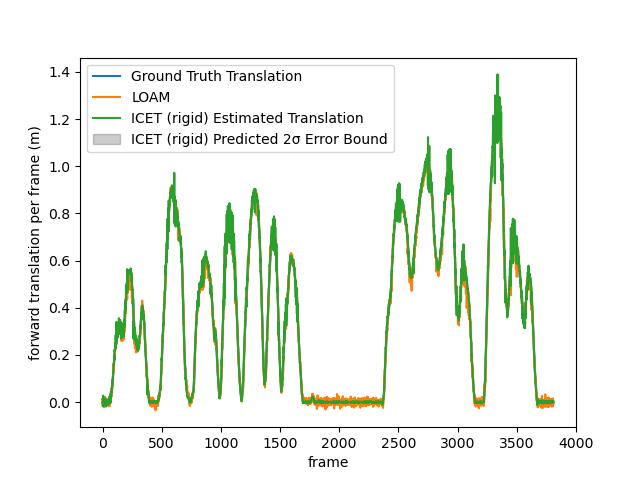

In [262]:
#load ground truth data and rigid transform ICET results
# estimates = np.loadtxt("../results/Ford_full_estimates_v10.txt") #was this
# pred_stds = np.loadtxt("../results/Ford_full_pred_stds_v10.txt")
estimates = np.loadtxt("../Ford_full_estimates_v12.txt") #test 5/8/23
pred_stds = np.loadtxt("../Ford_full_pred_stds_v12.txt")

ground_truth = np.loadtxt("../spherical_paper/FORD_results/truth_body_frame.txt") # [0, v_xandy, v_vertical, r, p, y]
LOAM = np.loadtxt("../spherical_paper/FORD_results/LOAM.txt")
# LOAM = np.loadtxt("../spherical_paper/FORD_results/LOAM_v2.txt")
ICP = np.loadtxt("../spherical_paper/FORD_results/ICP.txt")
# NDT = np.loadtxt("../spherical_paper/FORD_results/NDT_cart_v2.txt") #very bad
runlen = np.shape(estimates)[0]
estimates = estimates[1:,:]
pred_stds = pred_stds[1:,:]
vf = (ground_truth[:runlen-1,1]/10 + ground_truth[1:runlen,1]/10)/2 #v5

#plot ground truth vs raw ICET estimates
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(vf, label = 'Ground Truth Translation')
# print(estimates[:,0])
ax.plot(LOAM[:,1], label = "LOAM")
ax.plot(estimates[:,1], label = "ICET (rigid) Estimated Translation") #was this
#NOTE-- adjust linspace here when shifting
ax.fill_between(np.linspace(0,runlen-2,runlen-1),
                   vf - 2*pred_stds[:,1], vf + 2*pred_stds[:,1], 
                   color = [0,0,0], alpha = 0.2, label = 'ICET (rigid) Predicted 2σ Error Bound')
ax.set_xlabel("frame")
ax.set_ylabel("forward translation per frame (m)")
ax.legend(loc = 'best')

## Full Ford Datset

In [296]:
from linear_corrector import LC
import mat4py

start_idx = 0 #990 #start on this scan
runlen = 3680 #250
m_hat_history = np.zeros([runlen, 6])
X_hat_history = np.zeros([runlen, 6])
X_hat_history_ICET = np.zeros([runlen, 6])
seed_hist = np.zeros([runlen, 6])

A0 = np.array([0., 0, 0, 0, 0, 0,
               0., 0, 0, 0, 0, 0])

for i in range(runlen):
    print("---------------------------------- SCAN IDX", i + start_idx,"-------------------------------------")

    #load point clouds
    fn1 = '/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/Scan%04d.mat' %(i+start_idx+75)
    fn2 = '/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/Scan%04d.mat' %(i+start_idx+76)
    dat1 = mat4py.loadmat(fn1)
    SCAN1 = dat1['SCAN']
    pc1 = np.transpose(np.array(SCAN1['XYZ']))
    dat2 = mat4py.loadmat(fn2)
    SCAN2 = dat2['SCAN']
    pc2 = np.transpose(np.array(SCAN2['XYZ']))

    #align point clouds using ground truth
    ground_truth = np.loadtxt("/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/FORD_DS1_truth.txt")/10
    ground_truth = tf.cast(tf.convert_to_tensor(ground_truth), tf.float32)
    gt = (ground_truth[i+start_idx,:] + ground_truth[i+start_idx+1,:])/2 #avg between pts
        
    #flip order in which points appear in each cloud (so scanner spins ccw in stead of cw)
    pc1 = np.flip(pc1, axis = 0)
    pc2 = np.flip(pc2, axis = 0)
    #need to rotate point clouds so the scan starts aligned with +x axis
    rot = R_tf(np.array([0,0,-np.pi/2])).numpy()
    pc1 = pc1 @ rot
    pc2 = pc2 @ rot

#     #apply "ground truth" transform to point clouds
#     trans = np.array([gt[1], gt[0], gt[2]])
#     trans[0] += 0.01 #add noise to x
#     rot = R_tf(-gt[3:]).numpy().T
#     pc2_transformed =  (pc2 @ rot) + trans 
    
#     print("\n trans, rot GT: \n", trans, -gt[3:].numpy())

    
#     #apply output of ICET to raw point clouds ~~~~~~~~~~~~~~~~~~~
#     #align point clouds using ICET output, seed ICET input with ground truth to ensure convergence
#     it = ICET(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 10, 
#            draw = False, group = 2, RM = True, DNN_filter = False, x0 = gt)
#     #ViewInteractiveWidget(it.plt.window)
#     gt = it.X
#     trans = it.X[:3].numpy()
#     rot = R_tf(-it.X[3:]).numpy().T
#     pc2_transformed =  (pc2 @ rot) + trans 
#     print("\n trans, rot it.X \n", trans, -it.X[3:].numpy())
#     #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
#     #run 12 State Rigid Transform + Distortion Correction
#     dc = LC(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 25, 
#         draw = False, mnp = 25, RM = True, solver = '12_state', max_buffer = 1.0)
    
    noise = 0.05*np.random.randn()
#     run 6 State Rigid Transform ONLY
    x0 = tf.constant([gt[1].numpy()+noise, 0, 0, 0, 0, 0], tf.float32)
    it = ICET(cloud1 = pc1, cloud2 = pc2, fid = 70, niter = 10, x0 = x0,
           draw = False, group = 2, RM = True, DNN_filter = False)
    seed_hist[i,0] = gt[1].numpy()+noise
    
#     #seed initial alignments close to GT solution
#     A0 = np.array([gt[1]+noise, 0, 0, 0, 0, 0,
#                    0,           0, 0, 0, 0, 0])
    #seed initial alignments close to ICET solution
    A0 = np.array([it.X[0], it.X[1], it.X[2], it.X[3], it.X[4], it.X[5],
                   0., 0., 0., 0., 0., 0.])
#     A0[:6] = np.array([it.X[0], it.X[1], it.X[2], it.X[3], it.X[4], it.X[5]])
#     run 12 State Rigid Transform + Distortion Correction
    dc = LC(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 5, A0 = A0,
        draw = False, mnp = 50, RM = False, solver = '12_state', max_buffer = 0.3)
#     if A0[6] < 0.05:
#         A0[6:] = dc.A[6:] #test feeding last distortion bounds as input for next iter
#     else:
#         A0[6:] = np.array([0., 0., 0., 0., 0., 0.]) #zero out if they get too big
        
#     #zero out initial estimates (assume rigid ICET got us most of the way there)
#     A0 = np.array([0., 0, 0, 0, 0, 0,
#                    0, 0, 0, 0, 0, 0])
#     #run 12 State on STATIC portions of clouds ONLY
#     dc = LC(cloud1 = it.cloud1_static, cloud2 = it.cloud2_static, fid = 50, niter = 10, A0 = A0,
#         draw = False, mnp = 50, RM = False, solver = '12_state', max_buffer = 0.3)
    
    X_hat_history[i,:] = dc.A[:6] #when feeding output of rigid ICET as x0
#     X_hat_history[i,:] = dc.A[:6] + it.X #when using "static PC" output
    m_hat_history[i,:] = dc.A[6:]
    X_hat_history_ICET[i,:] = it.X

---------------------------------- SCAN IDX 990 -------------------------------------
iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor([ 0.02195656 -0.00055947 -0.00029823  0.00013629 -0.00018643 -0.00031788], shape=(6,), dtype=float32)
A0:
 [ 0.02195656 -0.00055947 -0.00029823  0.00013629 -0.00018643 -0.00031788
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.0193 -0.0053 -0.001   0.0004 -0.0005 -0.0013] 
 [-0.0015 -0.0029  0.0002

iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 2.9890273e-02 -4.2822966e-03  1.0952896e-03  3.4525586e-04
  4.3167081e-05  1.2784223e-04], shape=(6,), dtype=float32)
A0:
 [ 2.98902728e-02 -4.28229664e-03  1.09528960e-03  3.45255859e-04
  4.31670815e-05  1.27842228e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.0282 -0.0036  0.0022 -0.0005  0.0006  0.0002] 
 [-0.001   0.0005 -0.0006  0.0013 -0.0008  0.0002]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-1.24469418e-05  1.05257889e-05  1.80753015e-05 ...  9.66650519e-04
  9.45473584e-04  9.40408459e-04]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.0431 -0.0043 -0.0011  0.0002 -0.0001  0.0001] 
 [ 0.     -0.0004  0.0003 -0.0004  0.0001 -0.0001]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 9.38665029e-08  1.90486000e-07 -1.60092072e-07 ... -1.47401335e-05
 -1.43685811e-05 -1.42422760e-05]
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.0433 -0.0046 -0.0004  0.0002 -0.      0.0001] 
 [ 0.0001 -0.0005 -0.0015 -0.0006  0.     -0.0002]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [ 9.03365981e-07  1.83476039e-06 -1.54458691e-06 ... -1.42089306e-04
 -1.38507195e-04 -1.37289631e-04]
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 d


 delta_A
 (12,)
A: 
 [ 0.0535  0.0015 -0.0021  0.0008 -0.0007 -0.0003] 
 [-0.0003 -0.0003  0.0038 -0.0005  0.0011  0.0002]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [ 1.33969967e-06 -6.88310376e-07  2.24638569e-06 ...  2.69932036e-04
  2.64035762e-04  2.62624935e-04]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.0535  0.0015 -0.0021  0.0007 -0.0008 -0.0003] 
 [-0.0003 -0.0003  0.0041 -0.0005  0.0012  0.0002]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [ 1.30651459e-06 -6.70995580e-07  2.19074123e-06 ...  2.63212105e-04
  2.57462371e-04  2.56086670e-04]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.0535  0.0015 -0.0021  0.0007 -0.0008 -0.0003] 
 [-0.0003 -0.0004  0.0044 -0.0004  0.0012  0.0002]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [ 1.30523670e-06 -6.70386237e-07

num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.081  -0.0028 -0.0049  0.0013 -0.0008  0.0014] 
 [ 0.0027 -0.0016  0.0118  0.0003  0.0002 -0.0029]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [ 3.36024723e-05 -3.05164990e-05 -5.15573361e-05 ... -2.70292358e-03
 -2.64389508e-03 -2.62977355e-03]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.0813 -0.0029 -0.0055  0.0013 -0.0008  0.0014] 
 [ 0.0029 -0.0016  0.0128  0.0002  0.0002 -0.003 ]
---------------------------------- SCAN IDX 1003 -------------------------------------
iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for

iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor([ 0.1422192  -0.00153362 -0.00303012  0.00020642  0.00036226 -0.00016735], shape=(6,), dtype=float32)
A0:
 [ 0.1422192  -0.00153362 -0.00303012  0.00020642  0.00036226 -0.00016735
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.1425 -0.0025 -0.0087  0.0008 -0.0008  0.    ] 
 [ 0.0001 -0.0005  0.0128 -0.0001  0.0019 -0.0005]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-3.80374246e-07


 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 1.5648371e-01 -2.4949377e-03 -1.0329175e-03 -5.0682866e-04
  2.4208706e-05  3.2385893e-04], shape=(6,), dtype=float32)
A0:
 [ 1.56483710e-01 -2.49493774e-03 -1.03291753e-03 -5.06828655e-04
  2.42087062e-05  3.23858927e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 1.607e-01 -2.900e-03 -3.000e-04 -8.000e-04 -1.000e-04  5.000e-04] 
 [ 0.0025 -0.0007 -0.0026  0.0003 -0.0001 -0.001 ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 3.14647432e-05 -4.25333715e-05 -2.7672687

iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 2.4633875e-01 -1.9572710e-03 -1.5768635e-03 -1.3354581e-04
  3.0370086e-04 -2.6226742e-05], shape=(6,), dtype=float32)
A0:
 [ 2.46338755e-01 -1.95727102e-03 -1.57686346e-03 -1.33545807e-04
  3.03700857e-04 -2.62267422e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([197], shape=(1,), dtype=int32)
LUT tf.Tensor([197   3   3], shape=(3,), dtype=int32)

 residuals (591, 1)

 delta_A
 (12,)
A: 
 [ 2.43e-01 -1.80e-03 -2.70e-03 -3.00e-04  0.00e+00 -1.00e-04] 
 [-0.0019  0.0005  0.0018  0.0

iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor([ 0.29560804 -0.00151031  0.0019907   0.00122705 -0.00034552 -0.00041245], shape=(6,), dtype=float32)
A0:
 [ 0.29560804 -0.00151031  0.0019907   0.00122705 -0.00034552 -0.00041245
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 2.959e-01 -1.300e-03  9.000e-04  7.000e-04 -5.000e-04 -1.000e-04] 
 [ 0.0001 -0.      0.0004  0.0009 -0.0001 -0.0007]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 

iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 3.5340953e-01 -4.9437690e-03  4.0492970e-03  6.6553557e-04
  3.1135092e-04 -5.3042802e-04], shape=(6,), dtype=float32)
A0:
 [ 3.53409529e-01 -4.94376896e-03  4.04929696e-03  6.65535568e-04
  3.11350916e-04 -5.30428020e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 3.506e-01 -2.700e-03 -1.400e-03  1.000e-04 -2.000e-04  2.000e-04] 
 [-0.0017  0.0016 -0.003

iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 4.3278953e-01 -1.1476573e-02 -4.9697417e-03  2.0570160e-04
  3.0638685e-04 -4.9216748e-04], shape=(6,), dtype=float32)
A0:
 [ 4.32789534e-01 -1.14765726e-02 -4.96974168e-03  2.05701595e-04
  3.06386850e-04 -4.92167484e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([193], shape=(1,), dtype=int32)
LUT tf.Tensor([193   3   3], shape=(3,), dtype=int32)

 residuals (579, 1)

 delta_A
 (12,)
A: 
 [ 4.302e-01 -9.500e-03 -2.400e-03 -4.000e-04  2.000e-04 -5.000e-04] 
 [-0.0014  0.001   0.005

iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 4.0681082e-01 -7.9086591e-03 -2.6843157e-03  1.3665590e-04
 -1.5864962e-03 -9.4910647e-04], shape=(6,), dtype=float32)
A0:
 [ 4.06810820e-01 -7.90865906e-03 -2.68431567e-03  1.36655901e-04
 -1.58649625e-03 -9.49106470e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([202], shape=(1,), dtype=int32)
LUT tf.Tensor([202   3   3], shape=(3,), dtype=int32)

 residuals (606, 1)

 delta_A
 (12,)
A: 
 [ 4.024e-01 -1.020e-02 -3.800e-03  2.000e-04 -1.900e-03 -3.000e-04] 
 [-0.0027 -0.001   0.004


 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 4.8407111e-01 -1.1879541e-02 -1.9309591e-03 -2.0967245e-03
 -1.1187746e-03 -1.4692919e-04], shape=(6,), dtype=float32)
A0:
 [ 4.84071106e-01 -1.18795410e-02 -1.93095906e-03 -2.09672446e-03
 -1.11877464e-03 -1.46929189e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 4.78e-01 -1.07e-02 -1.50e-03 -2.30e-03 -1.30e-03 -2.00e-04] 
 [-0.0033 -0.0052 -0.      0.0015 -0.0007  0.0002]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-2.07231167e-05 -4.19740372e-05 -1.78981919e-05 

iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 5.7446921e-01 -2.7104397e-03 -1.4170213e-02 -2.5267908e-03
  3.9719781e-04  2.3628079e-05], shape=(6,), dtype=float32)
A0:
 [ 5.74469209e-01 -2.71043973e-03 -1.41702127e-02 -2.52679083e-03
  3.97197815e-04  2.36280794e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.5672  0.0403 -0.0077 -0.0023  0.0009 -0.0027] 
 [-0.0107 -0.0773  0.0035  0.0011 -0.0014  0.0065]
~~~~~~~~~~~I

iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor([ 0.65691066 -0.02033347  0.00373906  0.00363305 -0.00088495 -0.00083292], shape=(6,), dtype=float32)
A0:
 [ 0.65691066 -0.02033347  0.00373906  0.00363305 -0.00088495 -0.00083292
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 6.585e-01 -1.370e-02  6.200e-03  1.600e-03 -1.900e-03 -3.000e-04] 
 [ 0.0008  0.002  -0.0075  0.0019  0.0015 -0.0007]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 4.95245642e-06  1.00646181e-05  4.29520650e-06 ... -7.83494992e-04
 -7.78518859e-04 -7.74444924e-04]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 

A0:
 [ 0.57669514 -0.00130981 -0.00402696 -0.00456059  0.00091861 -0.00103582
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.5728 -0.0027  0.0009 -0.0062  0.0014 -0.0009] 
 [-0.0017 -0.0002  0.0019  0.0031 -0.002  -0.0005]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-1.04491299e-05 -2.12500181e-05 -8.97805778e-06 ...  1.65437694e-03
  1.64384886e-03  1.63520859e-03]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.5701 -0.0047 -0.0055 -0.0052  0.0014 -0.0011] 
 [-0.0028 -0.0009  0.01    0.002  -0.0018 -0.0001]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [-1.75520544e-05 -3.55785850e-05 -1.51114399e-05 ...  2.76124248e-03
  2.74366921e-


 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.5592 -0.0109 -0.0051  0.001   0.0032 -0.002 ] 
 [-0.0037 -0.0015 -0.004   0.0017 -0.0023  0.0016]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-2.27556011e-05 -4.60419366e-05 -1.98612817e-05 ...  3.58020782e-03
  3.55747137e-03  3.53883705e-03]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.5596 -0.0119 -0.004   0.001   0.0035 -0.0023] 
 [-0.0034 -0.002  -0.0074  0.0018 -0.0031  0.002 ]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [-2.15737379e-05 -4.34801281e-05 -1.88503451e-05 ...  3.36779311e-03
  3.34640284e-03  3.32887193e-03]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.5599 -0.0121

num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 6.662e-01 -2.190e-02 -1.170e-02 -2.000e-03 -1.300e-03  4.000e-04] 
 [ 0.0206  0.0338  0.0283  0.0011  0.0035 -0.0021]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [ 0.00012666  0.00025737 -0.00033506 ... -0.02012302 -0.01999503
 -0.01989099]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 6.646e-01 -2.660e-02 -1.210e-02 -2.100e-03 -1.500e-03  4.000e-04] 
 [ 0.0244  0.0394  0.0301  0.0014  0.0037 -0.0022]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [ 0.00014996  0.00030464 -0.00039595 ... -0.02379975 -0.02364833
 -0.02352524]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 6.633e-01 -3.050e-02 -1.210e-02 -2.200e-03 -1.500e-03  3.00

num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 6.812e-01 -2.310e-02 -9.300e-03  3.600e-03  3.000e-04 -2.800e-03] 
 [-0.0037  0.0028  0.0152  0.0022  0.0022  0.0027]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [-2.39832424e-05 -4.77234903e-05  6.02351452e-05 ...  3.71029815e-03
  3.62274489e-03  3.59421053e-03]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 6.813e-01 -2.310e-02 -9.800e-03  3.500e-03  3.000e-04 -2.800e-03] 
 [-0.0037  0.0028  0.0168  0.0023  0.0023  0.0027]
---------------------------------- SCAN IDX 1046 -------------------------------------
iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving

num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 0.6811 -0.1312  0.0065 -0.0026 -0.0019  0.0022] 
 [ 0.0514  0.1643  0.0073  0.0034  0.001  -0.0069]
---------------------------------- SCAN IDX 1049 -------------------------------------
iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 6.2255865e-01  6.0828408e-04 -1.6636847e-02 -2.5885110e-03
 -3.5609377e-03 -1.6955719e-05], shape=(6,), dtype=float32)
A0:
 [ 6.22558653e-01  6.08284085e-04 -1.66368466e-02 -2.58851098e-03
 -3.56093771e-03 -1.69557188e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00

iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 6.4639616e-01 -1.7015666e-02 -3.0037099e-03  6.1049261e-03
  3.8893744e-03  1.4196128e-04], shape=(6,), dtype=float32)
A0:
 [ 6.46396160e-01 -1.70156658e-02 -3.00370995e-03  6.10492611e-03
  3.88937443e-03  1.41961282e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.6499 -0.0138  0.0051  0.0046  0.0056 -0.0012] 
 [ 0.0026  0.0015 -0.01    0.0014 -0.0033 

iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 7.4051404e-01  4.9756840e-03 -5.7461518e-03 -4.2343950e-03
 -2.0865309e-03 -3.0848707e-04], shape=(6,), dtype=float32)
A0:
 [ 7.40514040e-01  4.97568399e-03 -5.74615179e-03 -4.23439499e-03
 -2.08653091e-03 -3.08487070e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 7.36e-01  1.00e-04 -1.05e-02 -3.50e-03 -2.80e-03 -1.00e-04] 
 [-0.0031 -0.0016  0.0126 -0.0

iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 7.6622802e-01 -1.8902740e-02 -1.0231618e-02  3.4748889e-03
  4.3993238e-03 -1.0287514e-05], shape=(6,), dtype=float32)
A0:
 [ 7.66228020e-01 -1.89027395e-02 -1.02316178e-02  3.47488886e-03
  4.39932384e-03 -1.02875138e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([197], shape=(1,), dtype=int32)
LUT tf.Tensor([197   3   3], shape=(3,), dtype=int32)

 residuals (591, 1)

 delta_A
 (12,)
A: 
 [ 7.629e-01 -1.980e-02  1.100e-03  1.400e-03  5.100e-03  6.000e-04] 
 [-0.0023 -0.0002 -0.0034  0.0035 -0.0024 -0.

iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 7.4992257e-01 -1.4552000e-02  7.5232182e-03 -9.0754073e-04
 -3.1951175e-04  9.2064840e-04], shape=(6,), dtype=float32)
A0:
 [ 7.49922574e-01 -1.45520000e-02  7.52321817e-03 -9.07540729e-04
 -3.19511746e-04  9.20648396e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([199], shape=(1,), dtype=int32)
LUT tf.Tensor([199   3   3], shape=(3,), dtype=int32)

 residuals (597, 1)

 delta_A
 (12,)
A: 
 [ 7.56e-01 -7.19e-02 -1.00e-03 -5.00e-04 -1.30e-03  3.70e-03] 
 [-0.0004  0.0933 -0.0018 -0.0

iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 7.4776888e-01 -6.6757770e-03 -5.5176243e-03  1.9285992e-03
 -2.2321941e-05 -4.4530607e-05], shape=(6,), dtype=float32)
A0:
 [ 7.47768879e-01 -6.67577703e-03 -5.51762432e-03  1.92859920e-03
 -2.23219413e-05 -4.45306068e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 7.512e-01 -7.200e-03 -6.000e-04  1.600e-03  3.000e-04  6.000e-04] 
 [ 0.002  -0.0007 -0.001

iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 7.7460438e-01 -3.8150087e-02 -7.5951527e-04 -2.0155660e-03
 -2.1309175e-03 -1.4240558e-03], shape=(6,), dtype=float32)
A0:
 [ 7.74604380e-01 -3.81500870e-02 -7.59515271e-04 -2.01556599e-03
 -2.13091751e-03 -1.42405578e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 0.7609 -0.0573 -0.0049 -0.0018 -0.0039 -0.0019] 
 [-0.009  -0.007   0.0137 -0.001   0.0052 

iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 8.3316767e-01 -1.5602286e-02  8.5421298e-03  1.0415198e-03
  6.5202388e-04  2.8704971e-04], shape=(6,), dtype=float32)
A0:
 [ 8.33167672e-01 -1.56022860e-02  8.54212977e-03  1.04151980e-03
  6.52023882e-04  2.87049712e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([197], shape=(1,), dtype=int32)
LUT tf.Tensor([197   3   3], shape=(3,), dtype=int32)

 residuals (591, 1)

 delta_A
 (12,)
A: 
 [ 8.414e-01 -1.150e-02  8.800e-03 -1.400e-03  5.000e-03  7.000e-04] 
 [ 0.0062  0.0002 -0.011   0.0051 -0.0074 -0.

iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 8.4239995e-01 -4.2668702e-03  2.9281937e-03 -2.5521268e-03
  3.8411194e-03  3.5235376e-04], shape=(6,), dtype=float32)
A0:
 [ 8.42399955e-01 -4.26687021e-03  2.92819366e-03 -2.55212677e-03
  3.84111935e-03  3.52353760e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.8373  0.0404  0.0111 -0.0037  0.0049  0.0012] 
 [-0.0048  0.0325 -0.0086  0.0021 -0.0024 

iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 7.6991814e-01 -8.8938633e-03 -1.0078679e-02  3.0825827e-03
  6.2499527e-04 -1.0981704e-03], shape=(6,), dtype=float32)
A0:
 [ 7.69918144e-01 -8.89386330e-03 -1.00786788e-02  3.08258273e-03
  6.24995271e-04 -1.09817041e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.7645 -0.0038  0.004   0.0015  0.0027 -0.0035] 
 [-0.0036 -0.011  -0.0198  0.0014 -0.0047 

iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 6.8134946e-01 -3.3124280e-04  7.8799929e-03 -1.0598836e-03
 -2.6037754e-03  2.8013205e-04], shape=(6,), dtype=float32)
A0:
 [ 6.81349456e-01 -3.31242802e-04  7.87999295e-03 -1.05988362e-03
 -2.60377536e-03  2.80132052e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([198], shape=(1,), dtype=int32)
LUT tf.Tensor([198   3   3], shape=(3,), dtype=int32)

 residuals (594, 1)

 delta_A
 (12,)
A: 
 [ 0.6753  0.0008 -0.0027 -0.0009 -0.0055  0.0016] 
 [-0.0049  0.0011 -0.0058 -0.0058  0.0048 

iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 7.8727323e-01 -9.1549056e-03 -6.9777500e-03  5.8706948e-03
 -1.9294454e-03  6.2192394e-04], shape=(6,), dtype=float32)
A0:
 [ 7.87273228e-01 -9.15490557e-03 -6.97774999e-03  5.87069476e-03
 -1.92944543e-03  6.21923944e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([197], shape=(1,), dtype=int32)
LUT tf.Tensor([197   3   3], shape=(3,), dtype=int32)

 residuals (591, 1)

 delta_A
 (12,)
A: 
 [ 7.716e-01 -8.500e-03 -1.220e-02  4.200e-03 -3.800e-03  5.000e-04] 
 [-0.0095  0.001   0.015

iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 7.5151753e-01 -7.5577325e-03  5.3789555e-03 -2.8782089e-03
 -2.2770658e-03  2.1127771e-04], shape=(6,), dtype=float32)
A0:
 [ 7.51517534e-01 -7.55773252e-03  5.37895551e-03 -2.87820888e-03
 -2.27706577e-03  2.11277715e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 7.398e-01 -2.100e-03 -7.500e-03 -2.600e-03 -3.300e-03 -5.000e-04] 
 [-0.0071  0.0037  0.020

iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 7.5923544e-01 -9.0933852e-03 -1.9663678e-02  1.1979330e-03
  1.0799230e-02  6.4911655e-05], shape=(6,), dtype=float32)
A0:
 [ 7.59235442e-01 -9.09338519e-03 -1.96636785e-02  1.19793299e-03
  1.07992301e-02  6.49116555e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 7.553e-01 -9.000e-03  1.060e-02 -8.000e-04  1.270e-02 -2.000e-04] 
 [-0.0023  0.0006 -0.017

iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 7.3389286e-01 -1.2711894e-02  5.1026447e-03 -7.1044939e-05
 -7.0334529e-03 -4.5889875e-04], shape=(6,), dtype=float32)
A0:
 [ 7.33892858e-01 -1.27118938e-02  5.10264467e-03 -7.10449385e-05
 -7.03345286e-03 -4.58898750e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 7.33e-01 -1.35e-02 -2.20e-03  6.00e-04 -7.70e-03 -8.00e-04] 
 [-0.0008 -0.0003  0.0091 -0.0

iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 7.3149335e-01 -6.8145804e-03 -6.5945662e-03  9.4131503e-04
  8.1946235e-04 -1.1199016e-04], shape=(6,), dtype=float32)
A0:
 [ 7.31493354e-01 -6.81458041e-03 -6.59456616e-03  9.41315026e-04
  8.19462352e-04 -1.11990157e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 7.275e-01 -6.700e-03 -8.000e-04 -8.000e-04  5.000e-04  4.000e-04] 
 [-0.0031  0.0003  0.0099  0.0031 -0.0012 -0.

iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 7.3372000e-01 -9.3608089e-03 -8.5810181e-03 -2.0936997e-04
  5.1177279e-03  3.6234999e-04], shape=(6,), dtype=float32)
A0:
 [ 7.33720005e-01 -9.36080888e-03 -8.58101808e-03 -2.09369973e-04
  5.11772791e-03  3.62349994e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([203], shape=(1,), dtype=int32)
LUT tf.Tensor([203   3   3], shape=(3,), dtype=int32)

 residuals (609, 1)

 delta_A
 (12,)
A: 
 [ 7.333e-01 -9.900e-03  3.000e-03 -2.300e-03  5.600e-03 -2.000e-04] 
 [-0.0003 -0.0003 -0.012

iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 7.8764063e-01 -1.8044950e-02 -1.6303528e-03  1.4405057e-03
 -1.3828765e-03 -1.8049697e-04], shape=(6,), dtype=float32)
A0:
 [ 7.87640631e-01 -1.80449504e-02 -1.63035281e-03  1.44050573e-03
 -1.38287654e-03 -1.80496965e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 7.863e-01 -6.210e-02  8.500e-03  6.000e-04 -2.300e-03 -1.100e-03] 
 [ 0.004   0.0562 -0.009

iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 7.6512581e-01 -8.6362539e-03 -1.1115699e-02  3.6302666e-04
 -2.4834664e-03 -3.7181322e-04], shape=(6,), dtype=float32)
A0:
 [ 7.65125811e-01 -8.63625389e-03 -1.11156991e-02  3.63026658e-04
 -2.48346641e-03 -3.71813221e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 7.15e-01 -4.67e-02 -7.80e-03  2.00e-04 -2.50e-03  9.00e-04] 
 [ 0.0653  0.0575  0.0027 -0.0003  0.0008 -0.0017]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 0.00038409  0.00079142  0.00033216 ... -0.06457989 -0.06303368
 -0.06253484]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.6908 -0.0085 -0.0043  0.0038 -0.0011 -0.0018] 
 [-0.0035 -0.008   0.0193 -0.0011  0.0033  0.0009]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-2.22603885e-05 -4.41820294e-05 -1.95483696e-05 ...  3.45811834e-03
  3.43845385e-03  3.39881405e-03]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 0.6913  0.0044 -0.0015  0.0029 -0.0013 -0.003 ] 
 [-0.0105 -0.0259  0.0201  0.0003  0.0039  0.003 ]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [-6.77618670e-05 -1.32929128e-04 -5.96563091e-05 ...  1.02788748e-02
  1.02206450e-02  1.01027022e-02]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 d


 new: 
 [ 1.17372189e-05  2.51466185e-05  9.92517925e-06 ... -2.11531068e-03
 -2.10326356e-03 -2.07890795e-03]
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 0.5941 -0.0024 -0.0201 -0.0017  0.0048  0.0047] 
 [ 0.0034  0.0029  0.033   0.0064 -0.0038 -0.0065]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [ 1.82163191e-05  3.94192374e-05  1.53649188e-05 ... -3.34564048e-03
 -3.32660914e-03 -3.28808756e-03]
num corr: 
 tf.Tensor([210], shape=(1,), dtype=int32)
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 5.953e-01  5.000e-04 -2.140e-02 -1.100e-03  4.800e-03  5.300e-03] 
 [ 0.0044  0.0037  0.0307  0.0047 -0.0043 -0.0076]
---------------------------------- SCAN IDX 1110 -------------------------------------
iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking fo


 delta_A
 (12,)
A: 
 [ 0.5763 -0.0949  0.0022  0.0032  0.001   0.0031] 
 [ 0.0014  0.1234 -0.0038 -0.004   0.0025 -0.0059]
---------------------------------- SCAN IDX 1113 -------------------------------------
iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 6.8324947e-01 -1.2285031e-02  1.9093642e-02  3.8778489e-03
  1.4778078e-04  8.2304893e-04], shape=(6,), dtype=float32)
A0:
 [ 6.83249474e-01 -1.22850314e-02  1.90936420e-02  3.87784885e-03
  1.47780782e-04  8.23048933e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([202], shap

iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 5.9118909e-01 -6.1656715e-04  6.5835033e-05  1.7848504e-03
 -4.6511027e-03 -4.3481021e-04], shape=(6,), dtype=float32)
A0:
 [ 5.91189086e-01 -6.16567151e-04  6.58350327e-05  1.78485038e-03
 -4.65110270e-03 -4.34810208e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 5.891e-01 -5.000e-04 -1.890e-02 -1.000e-04 -7.500e-03 -2.000e-03] 
 [-0.002  -0.0001  0.028


 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor([ 0.5186303  -0.01150883 -0.00712328  0.00126546  0.00337808  0.00178341], shape=(6,), dtype=float32)
A0:
 [ 0.51863033 -0.01150883 -0.00712328  0.00126546  0.00337808  0.00178341
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 5.138e-01 -1.550e-02 -8.500e-03 -3.200e-03  1.800e-03  1.000e-04] 
 [-0.0039 -0.0004  0.0412  0.0116  0.0013  0.0031]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-2.46694090e-05 -4.85952801e-05 -2.15218514e-05 ...  3.75838256e-03
  3.78759336e-03  3.72283275e-03]
num corr:

iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 5.3808618e-01 -7.0177563e-03 -2.5622699e-02  4.5473906e-04
  1.8735540e-03 -6.7114295e-04], shape=(6,), dtype=float32)
A0:
 [ 5.38086176e-01 -7.01775635e-03 -2.56226994e-02  4.54739056e-04
  1.87355396e-03 -6.71142945e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.535   0.0008 -0.0162 -0.0032  0.0009 -0.0007] 
 [-0.0025 -0.0112  0.0206  0.0099 -0.0003  0.0011]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 1.12389908e-05 -6.39095417e-06  1.95830906e-05 ...  2.48225155e-03
  2.46978575e-03  2.47479516e-03]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.5063 -0.0344  0.0437  0.009   0.0018  0.0012] 
 [ 0.0072  0.0309 -0.0684 -0.0203  0.0002 -0.0008]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 4.51632148e-05  9.07593648e-05  4.02893982e-05 ... -7.02151058e-03
 -6.98949557e-03 -6.95494988e-03]
num corr: 
 tf.Tensor([210], shape=(1,), dtype=int32)
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 0.504  -0.0429  0.0273  0.0083  0.      0.0012] 
 [ 0.0091  0.0428 -0.0369 -0.0177  0.0044 -0.0009]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [ 5.74396768e-05  1.15012776e-04  5.13170994e-05 ... -8.87864573e-03
 -8.83820864e-03 -8.79450399e-03]
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 d


 new: 
 [ 8.20785241e-06  1.63820458e-05  7.10895182e-06 ... -1.28568965e-03
 -1.27985184e-03 -1.27349596e-03]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 4.627e-01 -2.750e-02 -2.700e-03 -2.000e-04  1.600e-03  5.000e-04] 
 [ 0.0011  0.0225  0.0039 -0.0006 -0.0035 -0.0018]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [ 6.96030048e-06  1.39026389e-05  6.02877905e-06 ... -1.09201444e-03
 -1.08705501e-03 -1.08165758e-03]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32)
LUT tf.Tensor([213   3   3], shape=(3,), dtype=int32)

 residuals (639, 1)

 delta_A
 (12,)
A: 
 [ 4.621e-01 -3.000e-02 -3.200e-03 -2.000e-04  1.600e-03  7.000e-04] 
 [ 0.001   0.0268  0.0046 -0.0004 -0.0036 -0.002 ]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [ 5.93807148e-06  1.18685285e-05  5.14224845e-06 ... -9.32857977e-04
 -9.28621576e-04 -9.24010953e-04]
num corr: 
 tf.Tensor([213], shape=(1,), dtype=int32

num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 4.29e-01 -3.92e-02  1.01e-02  4.00e-04  3.00e-04  1.40e-03] 
 [ 0.0043  0.0441 -0.0154 -0.0003 -0.0013 -0.0016]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [ 2.70786147e-05  5.35884596e-05  2.36334536e-05 ... -4.25101723e-03
 -4.17396644e-03 -4.15319690e-03]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 4.293e-01 -4.880e-02  1.010e-02  3.000e-04  3.000e-04  1.500e-03] 
 [ 0.0051  0.0574 -0.0155 -0.0001 -0.0013 -0.002 ]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [ 3.23178724e-05  6.37769305e-05  2.82163606e-05 ... -5.04454205e-03
 -4.95288933e-03 -4.92825048e-03]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 4.297e-01 -5.760e


 new: 
 [ 2.76233523e-06  5.72224182e-06  2.37893790e-06 ... -4.72876241e-04
 -4.66473171e-04 -4.61971621e-04]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.3907 -0.0142  0.005   0.0016 -0.0019  0.0029] 
 [ 0.0006 -0.0014 -0.0099 -0.0005 -0.0006 -0.0031]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [ 3.19796055e-06  6.64603021e-06  2.75157848e-06 ... -5.50893719e-04
 -5.43435137e-04 -5.38190709e-04]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.3909 -0.014   0.0053  0.0017 -0.0019  0.0032] 
 [ 0.0007 -0.0014 -0.0108 -0.0008 -0.0007 -0.0035]
---------------------------------- SCAN IDX 1135 -------------------------------------
iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects--

num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 3.518e-01 -1.600e-03  5.000e-04 -1.000e-03 -2.000e-04 -5.000e-04] 
 [-0.0014 -0.     -0.0073 -0.0012 -0.0014 -0.0005]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [ 6.24327725e-06 -3.59815776e-06  1.07957854e-05 ...  1.35262401e-03
  1.34371733e-03  1.33675521e-03]
num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 3.519e-01 -1.600e-03  5.000e-04 -9.000e-04 -2.000e-04 -6.000e-04] 
 [-0.0013 -0.     -0.0074 -0.0015 -0.0014 -0.0004]
---------------------------------- SCAN IDX 1138 -------------------------------------
iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving

iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor([ 0.2972924  -0.00734821  0.00388893  0.00158605  0.00040546  0.0007923 ], shape=(6,), dtype=float32)
A0:
 [ 0.29729241 -0.00734821  0.00388893  0.00158605  0.00040546  0.0007923
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.3007 -0.0072 -0.0053  0.0022 -0.0004  0.001 ] 
 [ 0.0022 -0.0005  0.0031 -0.0022  0.0011 -0.0007]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 1.37060822e-05 


 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 2.6231471e-01 -2.9860989e-03  4.5726305e-05  1.4098595e-03
 -3.9208328e-04  5.9482228e-04], shape=(6,), dtype=float32)
A0:
 [ 2.62314707e-01 -2.98609887e-03  4.57263050e-05  1.40985951e-03
 -3.92083282e-04  5.94822282e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.2565 -0.0032  0.0015  0.0005 -0.0011  0.0007] 
 [-0.0037  0.0011 -0.0038  0.0004  0.0008 -0.    ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 1.75197918e-05 -9.19677123e-06  2.97767514e-05 ...  3.64718

iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 2.1862192e-01  1.7663282e-03 -8.1238924e-03 -2.9128308e-03
 -4.4038043e-05  5.6586310e-04], shape=(6,), dtype=float32)
A0:
 [ 2.18621925e-01  1.76632823e-03 -8.12389236e-03 -2.91283079e-03
 -4.40380427e-05  5.65863098e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 2.202e-01  8.000e-04  4.700e-03 -2.100e-03  1.000e-03  1.000e-04] 
 [ 0.0009 -0.001  -0.0061  0.001  -0.0023  0.0007]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 5.86936827e-06  1.15772901e-05  5.10191489e-06 ... -9.04823164e-04
 -8.99727198e-04 -8.89127590e-04]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.T

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.1769 -0.0054 -0.0036  0.0009 -0.0019  0.    ] 
 [-0.0001  0.0001  0.0091  0.0007  0.0023  0.0005]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-3.74775341e-07 -7.35118706e-07 -3.26973896e-07 ...  5.66818318e-05
  5.64252427e-05  5.61285553e-05]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.177  -0.0056 -0.0015  0.0008 -0.0018 -0.0007] 
 [-0.      0.0002  0.0068  0.0009  0.0021  0.0016]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [-1.09665233e-07 -2.13327360e-07 -9.59049366e-08 ...  1.63039117e-05
  1.62301057e-05  1.61447538e-05]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 d

num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 1.585e-01 -1.800e-03  1.000e-04 -3.000e-04  5.000e-04 -3.000e-04] 
 [ 0.0063 -0.0016 -0.0007 -0.0001 -0.0008  0.0014]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [-3.03305325e-05  1.55553184e-05 -5.12107886e-05 ... -6.20970651e-03
 -6.05524715e-03 -6.00306356e-03]
num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.1591 -0.0019 -0.0004 -0.0003  0.0005 -0.0004] 
 [ 0.0065 -0.0017 -0.0001 -0.0001 -0.0008  0.0016]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [-3.13610316e-05  1.62026255e-05 -5.30043006e-05 ... -6.43699307e-03
 -6.27689157e-03 -6.22280228e-03]
num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.1591 -0.002  -0.0007 -0.000

num corr: 
 tf.Tensor([219], shape=(1,), dtype=int32)
LUT tf.Tensor([219   3   3], shape=(3,), dtype=int32)

 residuals (657, 1)

 delta_A
 (12,)
A: 
 [ 0.1259 -0.0005 -0.0066  0.0006 -0.0014 -0.0013] 
 [ 0.0029 -0.001   0.0089 -0.0012  0.0007  0.0025]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [-1.41829625e-05  7.38773415e-06 -2.39523445e-05 ... -2.86419419e-03
 -2.84551389e-03 -2.83044494e-03]
num corr: 
 tf.Tensor([219], shape=(1,), dtype=int32)
LUT tf.Tensor([219   3   3], shape=(3,), dtype=int32)

 residuals (657, 1)

 delta_A
 (12,)
A: 
 [ 0.1258 -0.0005 -0.0068  0.0006 -0.0014 -0.0015] 
 [ 0.0029 -0.001   0.0092 -0.0013  0.0008  0.0027]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [-1.39643246e-05  7.36199197e-06 -2.36223833e-05 ... -2.83168992e-03
 -2.81322124e-03 -2.79832293e-03]
num corr: 
 tf.Tensor([219], shape=(1,), dtype=int32)
LUT tf.Tensor([219   3   3], shape=(3,), dtype=int32)

 residuals (657, 1)

 delta_A
 (12,)
A: 
 [ 0.1258 -0.0006 -0.0069  0.0007 -0.0015 -0.0016]

num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.1012 -0.0071 -0.0011  0.0009 -0.0006 -0.0015] 
 [ 0.0006 -0.0005  0.0049 -0.0001  0.0006  0.0035]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [-2.64251289e-06  1.46726152e-06 -4.49964716e-06 ... -5.50401021e-04
 -5.36606223e-04 -5.31934484e-04]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.1009 -0.0072 -0.0008  0.0008 -0.0006 -0.0018] 
 [ 0.0003 -0.0005  0.0046 -0.      0.0006  0.0039]
---------------------------------- SCAN IDX 1160 -------------------------------------
iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for

num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.0739 -0.0025  0.0006  0.001   0.0001 -0.0015] 
 [-0.002  -0.0002 -0.0005 -0.0002 -0.0002  0.0029]
---------------------------------- SCAN IDX 1163 -------------------------------------
iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 6.6400796e-02 -4.9719387e-03  2.0633345e-03  7.7933521e-04
  9.3035247e-05  1.2299498e-04], shape=(6,), dtype=float32)
A0:
 [ 6.64007962e-02 -4.97193867e-03  2.06333445e-03  7.79335212e-04
  9.30352471e-05  1.22994985e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00

iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor([ 0.04810828 -0.00201013 -0.00017721  0.0004252   0.00015559  0.00017124], shape=(6,), dtype=float32)
A0:
 [ 0.04810828 -0.00201013 -0.00017721  0.0004252   0.00015559  0.00017124
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.0536 -0.0019  0.0002  0.0004  0.0002  0.0003] 
 [ 0.0031 -0.0014  0.0008  0.0002 -0.0001 -0.0005]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 3.88275754e-05


 estimated solution vector X: 
 tf.Tensor(
[ 3.2813735e-02  2.0555330e-03 -2.1718903e-03 -5.8622175e-04
  4.0034171e-05  2.6681344e-04], shape=(6,), dtype=float32)
A0:
 [ 3.28137353e-02  2.05553300e-03 -2.17189034e-03 -5.86221751e-04
  4.00341705e-05  2.66813440e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0357  0.0019 -0.0007 -0.0003  0.0001  0.0002] 
 [ 0.0018 -0.0007  0.0008  0.0001 -0.0002 -0.0001]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-8.87335169e-06  4.51987541e-06 -1.48571967e-05 ... -1.77515406e-03
 -1.73044821e-03 -1.71522103e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0367  0.001


 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0234  0.0023  0.0003 -0.0005  0.     -0.0002] 
 [ 0.0022 -0.0006  0.0002  0.0005 -0.      0.0003]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-1.06127460e-05  5.63351182e-06 -1.78753774e-05 ... -2.11994580e-03
 -2.10607529e-03 -2.09483738e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0249  0.0023  0.0003 -0.0005  0.     -0.0002] 
 [ 0.0032 -0.0007  0.0004  0.0005  0.      0.0003]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [-1.56537187e-05  8.31780330e-06 -2.63709622e-05 ... -3.12838924e-03
 -3.10792209e-03 -3.09133982e-03]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.0253  0.0022

LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.0145  0.0022 -0.0016  0.     -0.0002 -0.0006] 
 [ 0.0045 -0.0017  0.0017 -0.0003  0.0003  0.0006]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [ 5.67946409e-05  2.52112484e-05  4.35676211e-05 ... -4.40103718e-03
 -4.28998177e-03 -4.25210587e-03]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.0151  0.0022 -0.0017  0.     -0.0002 -0.0006] 
 [ 0.0048 -0.0018  0.002  -0.0003  0.0003  0.0007]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [ 6.14463413e-05  2.72998565e-05  4.71459325e-05 ... -4.75826137e-03
 -4.63819718e-03 -4.59725106e-03]
num corr: 
 tf.Tensor([218], shape=(1,), dtype=int32)
LUT tf.Tensor([218   3   3], shape=(3,), dtype=int32)

 residuals (654, 1)

 delta_A
 (12,)
A: 
 [ 0.0152  0.0022 -0.0017  0.     -0.0002 -0.0007] 
 [ 0.0049 -0.0018  0.002  -0.0003  0.0003  0.0008]
~

num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0166 -0.0006 -0.002  -0.001  -0.0005 -0.0009] 
 [ 0.0021 -0.0004  0.0004  0.0002 -0.0004  0.0011]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [ 1.34880318e-05  2.63604859e-05  1.17588631e-05 ... -2.00352841e-03
 -1.99041459e-03 -1.97977499e-03]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0165 -0.0006 -0.0021 -0.001  -0.0005 -0.0009] 
 [ 0.0021 -0.0004  0.0005  0.0001 -0.0004  0.0011]
---------------------------------- SCAN IDX 1179 -------------------------------------
iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for

iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor([ 0.04518097  0.00107604 -0.00350464 -0.00076923  0.00018027  0.00028557], shape=(6,), dtype=float32)
A0:
 [ 0.04518097  0.00107604 -0.00350464 -0.00076923  0.00018027  0.00028557
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.0589  0.001  -0.003  -0.0008  0.0001 -0.0003] 
 [ 0.007  -0.001   0.0031  0.0007 -0.0001  0.0006]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 8.90007586e-05

A0:
 [ 0.07489923  0.00204418 -0.00466805 -0.00073864  0.00074795  0.00092084
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.0704  0.002  -0.0027 -0.0002 -0.0001  0.0005] 
 [-0.0031  0.0004 -0.0007 -0.0006  0.0009  0.0007]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-1.87997160e-05 -3.85010895e-05 -1.65311485e-05 ...  3.07499463e-03
  2.99784620e-03  2.97168392e-03]
num corr: 
 tf.Tensor([217], shape=(1,), dtype=int32)
LUT tf.Tensor([217   3   3], shape=(3,), dtype=int32)

 residuals (651, 1)

 delta_A
 (12,)
A: 
 [ 0.0682  0.0019 -0.0019 -0.0006 -0.0002  0.0002] 
 [-0.0046  0.0005 -0.0003  0.0002  0.001   0.0013]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [-2.82247102e-05 -5.75525786e-05 -2.48428470e-05 ...  4.57606888e-03
  4.46117002e-

A: 
 [ 0.0723 -0.0038  0.0034  0.0021 -0.0022 -0.0001] 
 [ 0.0012 -0.0003  0.0068  0.0001  0.0016  0.0004]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [ 7.36333477e-06  1.53285463e-05  6.57230420e-06 ... -1.19665087e-03
 -1.18883862e-03 -1.18251385e-03]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0725 -0.0037  0.0037  0.0021 -0.0022 -0.    ] 
 [ 0.0013 -0.0002  0.0064  0.0002  0.0016  0.0004]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [ 7.99872140e-06  1.66589245e-05  7.13741832e-06 ... -1.30106316e-03
 -1.29256942e-03 -1.28569303e-03]
num corr: 
 tf.Tensor([214], shape=(1,), dtype=int32)
LUT tf.Tensor([214   3   3], shape=(3,), dtype=int32)

 residuals (642, 1)

 delta_A
 (12,)
A: 
 [ 0.0726 -0.0036  0.0041  0.002  -0.0021 -0.    ] 
 [ 0.0014 -0.0001  0.0059  0.0003  0.0015  0.0004]
---------------------------------- SCAN IDX 1189 -------------------------------------
iter 0

iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor([ 0.13574672 -0.00211758 -0.00133568  0.00022778  0.00068885  0.00190486], shape=(6,), dtype=float32)
A0:
 [ 0.13574672 -0.00211758 -0.00133568  0.00022778  0.00068885  0.00190486
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [ 0.1356 -0.0032  0.0003 -0.0006  0.0019  0.0023] 
 [-0.0001 -0.0008  0.0026  0.0023 -0.002  -0.0008]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 5.58569891e-07

A0:
 [ 0.18195775  0.00863913 -0.00609906 -0.00330252  0.00117633  0.00330545
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.1831  0.0074 -0.005  -0.003   0.0015  0.0039] 
 [ 0.0007 -0.0014 -0.0056 -0.001  -0.0005 -0.0012]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-3.23022841e-06  1.64436239e-06 -5.47078207e-06 ... -6.56830246e-04
 -6.52562916e-04 -6.49113537e-04]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [ 0.1843  0.0078 -0.0037 -0.0032  0.0015  0.0044] 
 [ 0.0013 -0.0016 -0.0077 -0.0008 -0.0007 -0.0019]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [-6.53906401e-06  3.19288361e-06 -1.10134289e-05 ... -1.31151900e-03
 -1.30299897e-

num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [2.314e-01 8.000e-04 1.900e-03 1.000e-04 1.200e-03 3.000e-03] 
 [ 0.0003  0.0006 -0.0014  0.0007 -0.0005  0.0009]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-1.35782911e-06  7.80854981e-07 -2.35512214e-06 ... -2.94359724e-04
 -2.89471773e-04 -2.87947748e-04]
num corr: 
 tf.Tensor([215], shape=(1,), dtype=int32)
LUT tf.Tensor([215   3   3], shape=(3,), dtype=int32)

 residuals (645, 1)

 delta_A
 (12,)
A: 
 [0.2311 0.0008 0.0009 0.0003 0.0012 0.0029] 
 [ 0.0001  0.0006 -0.0008  0.0006 -0.0005  0.0012]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [-4.97876462e-07  2.87464886e-07 -8.63973275e-07 ... -1.08089669e-04
 -1.06295065e-04 -1.05735440e-04]
num corr: 
 tf.Tensor([216], shape=(1,), dtype=int32)
LUT tf.Tensor([216   3   3], shape=(3,), dtype=int32)

 residuals (648, 1)

 delta_A
 (12,)
A: 
 [2.309e-01 7.000e-04 2.000e-04 4.000e-04 1.


 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 0.2574 -0.0028 -0.0064  0.0036 -0.0034  0.0006] 
 [-0.002  -0.      0.0171 -0.0016  0.0045  0.0062]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [-2.63728137e-05 -2.02614875e-05  3.31733378e-05 ...  2.02647928e-03
  1.98246204e-03  1.97206226e-03]
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 2.567e-01 -3.200e-03 -5.800e-03  3.600e-03 -3.400e-03 -2.000e-04] 
 [-0.0025  0.0001  0.0158 -0.0016  0.0044  0.0074]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [-3.20581296e-05 -2.46991736e-05  3.96598379e-05 ...  2.44035628e-03
  2.38733886e-03  2.37481290e-03]
num corr: 
 tf.Tensor([210], shape=(1,), dtype=int32)
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 0.2561 -0.0036 -0.0056  0.0035 -0.0034 -0.0008] 
 [-0.0028  0.0001  0.0156 -0.0014  0.0044  0.0084]
---------------------------------- SC

num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 0.3032 -0.0048  0.0007  0.001  -0.0015  0.0053] 
 [ 0.004   0.0109  0.0102 -0.0016  0.0012  0.0001]
---------------------------------- SCAN IDX 1205 -------------------------------------
iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor([ 0.35407448 -0.00727304  0.01874625  0.00415782 -0.00426788  0.00424689], shape=(6,), dtype=float32)
A0:
 [ 0.35407448 -0.00727304  0.01874625  0.00415782 -0.00426788  0.00424689
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new:

iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor([0.37027815 0.00106567 0.01369082 0.00091566 0.00063804 0.00537985], shape=(6,), dtype=float32)
A0:
 [0.37027815 0.00106567 0.01369082 0.00091566 0.00063804 0.00537985
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.3638  0.002   0.0113 -0.0012  0.002   0.0048] 
 [-0.004   0.0036 -0.0062  0.0021 -0.0019  0.0015]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [2.43925683e-05 6.62376969e-05 7.3

A0:
 [ 0.39566779  0.00979131 -0.01362091 -0.00472593 -0.00362148  0.00269092
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([206], shape=(1,), dtype=int32)
LUT tf.Tensor([206   3   3], shape=(3,), dtype=int32)

 residuals (618, 1)

 delta_A
 (12,)
A: 
 [ 0.3943  0.0109 -0.0085 -0.0061 -0.0027  0.0028] 
 [-0.0009 -0.0027 -0.0016  0.0023 -0.0018 -0.0002]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [5.45500937e-06 9.41525008e-06 1.62445157e-05 ... 8.79829345e-04
 8.65215101e-04 8.60593445e-04]
num corr: 
 tf.Tensor([205], shape=(1,), dtype=int32)
LUT tf.Tensor([205   3   3], shape=(3,), dtype=int32)

 residuals (615, 1)

 delta_A
 (12,)
A: 
 [ 0.3941  0.0079 -0.0111 -0.0057 -0.0026  0.0028] 
 [-0.0008  0.0024  0.0019  0.0018 -0.0016 -0.0002]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [4.79294612e-06 8.28152101e-06 1.42849045e-05 ... 7.73904302e-04
 7.61048585e-04 7.569824

num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 4.456e-01 -1.870e-02  4.200e-03  5.200e-03  4.000e-04  1.000e-04] 
 [ 0.0058 -0.0029 -0.0071 -0.0001  0.0062  0.0008]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [-2.96280953e-05 -3.50254416e-05 -1.00928122e-05 ... -5.71801767e-03
 -5.62382404e-03 -5.59389647e-03]
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 4.46e-01 -1.89e-02  4.70e-03  5.10e-03  4.00e-04 -0.00e+00] 
 [ 0.006  -0.0031 -0.0074  0.0001  0.0062  0.001 ]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [-3.07682756e-05 -3.64005561e-05 -1.04012692e-05 ... -5.96252098e-03
 -5.86428187e-03 -5.83307417e-03]
num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 4.46e-01 -1.90e-0

num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.4097 -0.0112 -0.0036 -0.0012  0.0017  0.002 ] 
 [-0.0017 -0.0022  0.0024 -0.0001 -0.0059 -0.0012]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [1.06363705e-05 2.87207471e-05 1.85120694e-05 ... 1.71724167e-03
 1.68880285e-03 1.67978472e-03]
num corr: 
 tf.Tensor([212], shape=(1,), dtype=int32)
LUT tf.Tensor([212   3   3], shape=(3,), dtype=int32)

 residuals (636, 1)

 delta_A
 (12,)
A: 
 [ 0.4098 -0.0113 -0.0036 -0.0012  0.0017  0.002 ] 
 [-0.0017 -0.0023  0.0026 -0.0001 -0.0059 -0.0013]
---------------------------------- SCAN IDX 1218 -------------------------------------
iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for movin

iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 4.7821948e-01 -3.0771019e-03 -7.8300918e-03 -8.9543819e-04
 -5.5371011e-03  2.5281668e-04], shape=(6,), dtype=float32)
A0:
 [ 4.78219479e-01 -3.07710189e-03 -7.83009175e-03 -8.95438192e-04
 -5.53710107e-03  2.52816681e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 0.4832 -0.005  -0.0108  0.0005 -0.0065  0.0021] 
 [ 0.0029 -0.0016 -0.0017 -0.0032  0.0033 

iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor([ 0.53930646 -0.02345991  0.00516022  0.00110642  0.00111718 -0.00404173], shape=(6,), dtype=float32)
A0:
 [ 0.53930646 -0.02345991  0.00516022  0.00110642  0.00111718 -0.00404173
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_A
 (12,)
A: 
 [ 5.25e-01 -2.08e-02  1.39e-02  2.00e-04  1.90e-03 -4.10e-03] 
 [-0.0081  0.003  -0.0107  0.0015 -0.0022  0.0011]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [ 3.72624072e-05 -2.01297081e-05  6.44677657e-05 ...  7.96966044e-03
  7.83813453e-03  7.79604376e-03]
num corr: 
 tf.Tensor([211], shape=(1,), dtype=int32)
LUT tf.Tensor([211   3   3], shape=(3,), dtype=int32)

 residuals (633, 1)

 delta_

num corr: 
 tf.Tensor([209], shape=(1,), dtype=int32)
LUT tf.Tensor([209   3   3], shape=(3,), dtype=int32)

 residuals (627, 1)

 delta_A
 (12,)
A: 
 [ 5.61e-01 -1.15e-02 -2.73e-02 -1.50e-03  8.20e-03  5.00e-04] 
 [ 0.0017 -0.0009  0.0065 -0.0004 -0.0074 -0.0008]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-1.02321150e-05 -2.74031394e-05 -3.00434563e-05 ... -1.63630095e-03
 -1.60930130e-03 -1.60064982e-03]
num corr: 
 tf.Tensor([210], shape=(1,), dtype=int32)
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 0.559  -0.0118 -0.0279 -0.0016  0.0085  0.0009] 
 [ 0.0006 -0.0005  0.0034 -0.0004 -0.0085 -0.0012]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [-3.90083770e-06 -1.03790978e-05 -1.13750929e-05 ... -6.17385331e-04
 -6.07197205e-04 -6.03932665e-04]
num corr: 
 tf.Tensor([210], shape=(1,), dtype=int32)
LUT tf.Tensor([210   3   3], shape=(3,), dtype=int32)

 residuals (630, 1)

 delta_A
 (12,)
A: 
 [ 0.5591 -0.0116 -0.0277 -0.0015  0.0


 delta_A
 (12,)
A: 
 [ 0.5838 -0.0501  0.0207 -0.      0.001  -0.0086] 
 [ 0.0031 -0.0134 -0.0235  0.0011  0.0082  0.0065]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~

 new: 
 [-1.32084201e-05 -1.62723932e-05 -5.44811732e-05 ... -3.09974105e-03
 -3.04824869e-03 -3.03213304e-03]
num corr: 
 tf.Tensor([208], shape=(1,), dtype=int32)
LUT tf.Tensor([208   3   3], shape=(3,), dtype=int32)

 residuals (624, 1)

 delta_A
 (12,)
A: 
 [ 5.807e-01 -5.840e-02  2.150e-02 -1.000e-04  1.000e-03 -1.020e-02] 
 [ 0.0013 -0.0161 -0.0245  0.0012  0.0081  0.0096]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~

 new: 
 [-5.15094463e-06 -6.42186156e-06 -2.23138126e-05 ... -1.28899692e-03
 -1.26754723e-03 -1.26083947e-03]
num corr: 
 tf.Tensor([207], shape=(1,), dtype=int32)
LUT tf.Tensor([207   3   3], shape=(3,), dtype=int32)

 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 5.773e-01 -6.470e-02  2.280e-02 -1.000e-04  1.100e-03 -1.140e-02] 
 [-0.0007 -0.018  -0.0269  0.0011  0.0079  0.0122]
---------------------------------- SCAN 


 residuals (621, 1)

 delta_A
 (12,)
A: 
 [ 0.5913 -0.0077 -0.005  -0.0028 -0.0023 -0.001 ] 
 [-0.0028  0.0046  0.0188  0.0004  0.0065  0.0002]
---------------------------------- SCAN IDX 1234 -------------------------------------
iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 6.0305554e-01 -1.7968627e-02 -1.1008151e-02  4.1987133e-04
 -1.7885398e-03 -2.7533781e-03], shape=(6,), dtype=float32)
A0:
 [ 6.03055537e-01 -1.79686267e-02 -1.10081509e-02  4.19871329e-04
 -1.78853981e-03 -2.75337812e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 

iter 0
iter 1
iter 2
iter 3

 ---checking for moving objects---
iter 4

 ---checking for moving objects---
iter 5

 ---checking for moving objects---
iter 6

 ---checking for moving objects---
iter 7

 ---checking for moving objects---
iter 8

 ---checking for moving objects---
iter 9

 ---checking for moving objects---

 estimated solution vector X: 
 tf.Tensor(
[ 6.5367526e-01 -9.0165231e-03 -6.2383725e-03 -3.7093987e-04
  5.1333229e-03 -3.4620112e-03], shape=(6,), dtype=float32)
A0:
 [ 6.53675258e-01 -9.01652314e-03 -6.23837253e-03 -3.70939873e-04
  5.13332291e-03 -3.46201123e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~

 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([204], shape=(1,), dtype=int32)
LUT tf.Tensor([204   3   3], shape=(3,), dtype=int32)

 residuals (612, 1)

 delta_A
 (12,)
A: 
 [ 0.621   0.      0.0138 -0.0013  0.0085 -0.0074] 
 [-0.0168  0.0206 -0.0234  0.0027 -0.0061 

<IPython.core.display.Javascript object>


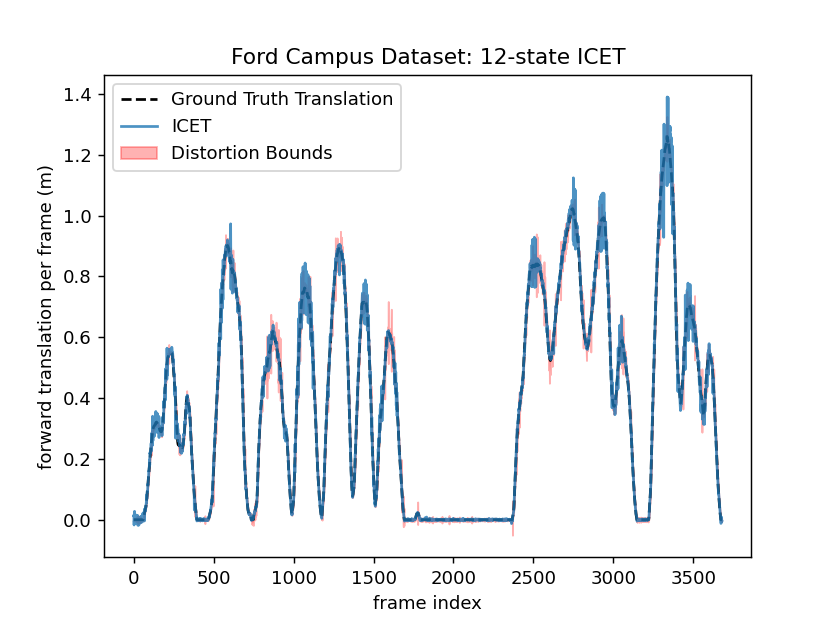

In [328]:
#plot updated bounds
pred_stds = np.loadtxt("../results/Ford_full_pred_stds_v10.txt")
pred_stds = pred_stds[(start_idx):(start_idx+runlen),:]

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ground_truth = np.loadtxt("/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/FORD_DS1_truth.txt")/10
ground_truth = tf.cast(tf.convert_to_tensor(ground_truth), tf.float32)
# gt = (ground_truth[i+start_idx,:] + ground_truth[i+start_idx+1,:])/2 #avg between pts
vf = (ground_truth[(start_idx+1):(start_idx+runlen+1),1] + ground_truth[start_idx:(start_idx+runlen),1])/2 #works best(?)
# vf = ground_truth[(start_idx+1):(start_idx+runlen+1),1] #test

ax.plot(vf, 'k--', label = 'Ground Truth Translation')
# ax.plot(estimates[start_idx:(start_idx+runlen),1], label = "ICET Estimated Translation (rigid)") #old rigid

# ax.plot(X_hat_history[1:,0], alpha = 0.8, label = "ICET Registration (12 State)")
# ax.plot(X_hat_history_ICET[:,0], alpha = 0.8, label = "ICET Registration (6 State)") #same params as 12 state
ax.plot(estimates[start_idx:(start_idx+runlen),1], alpha = 0.8, label = "ICET")#"ICET Registration (tuned 6 State)") #old full run optimized ICET
# ax.plot(seed_hist[:,0], 'k.', alpha = 0.3, label = "ICET initial seed" )
# ax.plot(LOAM[1:,1], alpha = 0.5, label = "LOAM")
# ax.plot(ICP[1:,1], 'g', alpha = 0.35, label = "ICP")
# ax.plot(NDT[1:,1], 'g--', alpha = 0.8, label = "NDT")

# ax.fill_between(np.linspace(0,runlen-1,runlen),
#                    vf - 2*pred_stds[:,1], vf + 2*pred_stds[:,1], 
#                    color = [0,0,0], alpha = 0.2, label = 'ICET Predicted 2σ Error Bound')

# ax.fill_between(np.linspace(0,runlen-1,runlen),
#                    vf - m_hat_history[:,0], vf + m_hat_history[:,0], 
#                    color = [1,0,0], alpha = 0.3, label = 'Distortion Bounds (12 State)')

# plot distortion bounds w.r.t. gt
ax.fill_between(np.linspace(0,runlen-2,runlen-1),
                   vf[:-1] - abs(m_hat_history[1:,0])-2*abs(pred_stds[1:,1]), 
                   vf[:-1] + abs(m_hat_history[1:,0]) + 2*abs(pred_stds[1:,1]), 
                   color = [1,0,0], alpha = 0.3, label = 'Distortion Bounds')
# ax.fill_between(np.linspace(0,runlen-3,runlen-2),
#                    vf[:-2] - abs(m_hat_history[2:,0])-2*abs(pred_stds[2:,1]), 
#                    vf[:-2] + abs(m_hat_history[2:,0]) + 2*abs(pred_stds[2:,1]), 
#                    color = [1,0,0], alpha = 0.3, label = '2σ + Distortion Bounds')

# # plot distortion bounds w.r.t. 12-State ICET Estimaes
# ax.fill_between(np.linspace(0,runlen-1,runlen),
#                    X_hat_history[:,0] - abs(m_hat_history[:,0])-2*abs(pred_stds[:,1]), 
#                    X_hat_history[:,0] + abs(m_hat_history[:,0]) + 2*abs(pred_stds[:,1]), 
#                    color = [1,0,0], alpha = 0.3, label = '2σ + 2*Distortion Bounds (12 State)')

ax.set_title("Ford Campus Dataset: 12-state ICET")
ax.set_xlabel("frame index")
ax.set_ylabel("forward translation per frame (m)")
ax.legend(loc = 'best')

In [327]:
# np.save("sample_data/Ford_m_hat_history_12_state_ICET_990",  m_hat_history) #250 frames
# np.save("sample_data/Ford_X_hat_history_12_state_ICET_990",  X_hat_history) #250 frames
# np.save("sample_data/Ford_12_state_seed_values_990", seed_hist) #250 frames

# np.save("sample_data/Ford_m_hat_history_12_state_ICET_full",  m_hat_history) 
# np.save("sample_data/Ford_X_hat_history_12_state_ICET_full",  X_hat_history) 
# np.save("sample_data/Ford_12_state_seed_values_full", seed_hist)
m_hat_history = np.load("sample_data/Ford_m_hat_history_12_state_ICET_full.npy")
X_hat_history = np.load("sample_data/Ford_X_hat_history_12_state_ICET_full.npy")
seed_hist = np.load("sample_data/Ford_12_state_seed_values_full.npy")
start_idx = 0 #990 #start on this scan
runlen = 3680 #250

#remove outliers from m_hat_history
m_hat_history[abs(m_hat_history[:,0]) > 0.1] = 0.1

### Plot Cumulative error between ICET, LOAM, and Ground Truth for forward motion (x)

<IPython.core.display.Javascript object>


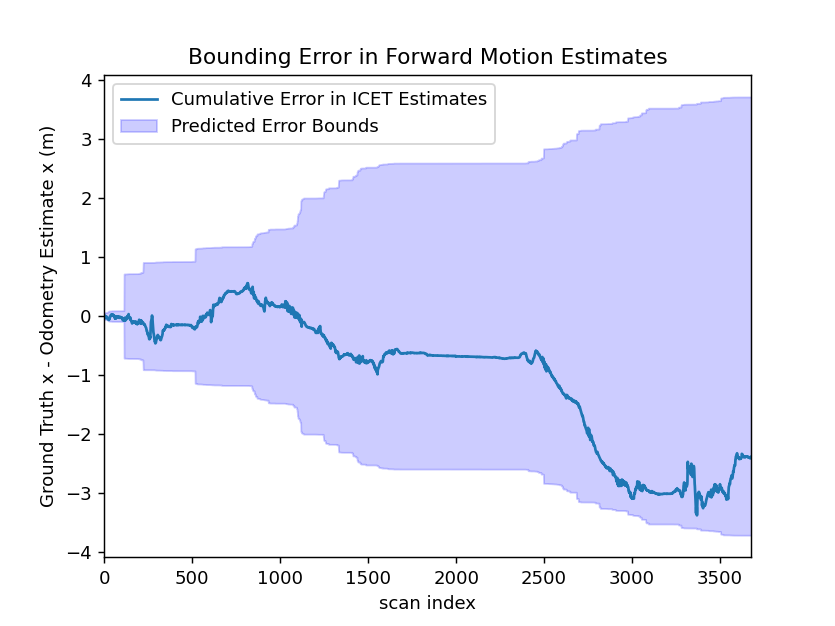

(0.0, 3678.0)

In [333]:
#plot error between ICET and absolute position
plt.rc('font',family='Times New Roman')
fig3, ax3 = plt.subplots(1,1)
font = {'fontname':'Times New Roman'}

c = 0 # x (forward movement)

# #DEBUG: why is GT continuously 0.005m short for frames 2400-3000??? #~~~~~~~~~
# vf = (ground_truth[(start_idx+1):(start_idx+runlen+1),1] + ground_truth[start_idx:(start_idx+runlen),1])/2 #works best(?)
# vf = vf.numpy()
# vf[2400:3000] += 0.005
# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#works best(??) -- tuned 6-state ICET
# diffx = vf - estimates[:len(vf),1] 
diffx = (vf/0.999) - estimates[:len(vf),1]  # need to rescale timestamps


#  # 12-state ICET rigid transform
# # vf = (ground_truth[(start_idx+2):(start_idx+runlen+2),1] + ground_truth[(start_idx+1):(start_idx+runlen+1),1])/2 #works best(?)
# # vf = (ground_truth[(start_idx+1):(start_idx+runlen+1),1] + ground_truth[start_idx:(start_idx+runlen),1])/2 #works best(?)
# vf = ground_truth[(start_idx):(start_idx+runlen),1]
# diffx = vf - X_hat_history[:len(vf),0]


# diffx_LOAM = vf - LOAM[len(vf),1]

# diffx = ground_truth[:len(estimates),5] - estimates[:,5]

cum_err = np.zeros(np.shape(pred_stds))
cum_diffx = np.zeros(np.shape(diffx))

for i in range(np.shape(pred_stds)[0]):
    #include sensor noise calculated by ICET 
    cum_err[i,:] = np.sum(pred_stds[:i,:]**2, axis = 0)
    #add in distortion bounds
    cum_err[i,:] += np.sum(m_hat_history[:i,:]**2, axis = 0)
    #add in baseline OXTS 1-sigma errors
    cum_err[i,:] += np.sqrt(2)*np.array([0.05,0.05,0.1,0.0005,0.0005,0.001])**2
#     cum_err[i,:] += np.sqrt(2)*np.array([0.08,0.08,0.1,0.0005,0.0005,0.001745])**2
    cum_err[i,:] = np.sqrt(cum_err[i,:]) 
    
for j in range(np.shape(diffx)[0]):
    cum_diffx[j] = np.sum(diffx[:j]) 

# # error for each individual timestep --------------------------------
# ax3.plot(diffx, label = 'GPS/INS - ICET (after bias reduction)')
# # ax3.fill_between(np.linspace(0,len(pred_stds)-1,len(pred_stds)), -2*pred_stds[:,c], 2*pred_stds[:,c], 
# #                  color = (0.5,0.5,0.5,0.4), label = 'ICET Predicted 2σ Error Bounds')
# ax3.fill_between(np.linspace(0,len(pred_stds)-1,len(pred_stds)), 
#                  -m_hat_history[:,0]  - 2*pred_stds[:,c], 
#                   m_hat_history[:,0] + 2*pred_stds[:,c], 
#                  color = (0.5,0.5,0.5,0.4), label = 'Predicted Error Bounds')
# #-------------------------------------------------------------------

# #new (accumulated differences in error)--------------------------
# ax3.plot(np.linspace(0,15,np.shape(ICET_pred_stds)[0]), cum_diffx_with_ground, label = 'GPS/INS - ICET')
ax3.plot(np.linspace(0,len(pred_stds)-1,len(pred_stds)), cum_diffx, label = 'Cumulative Error in ICET Estimates')
ax3.fill_between(np.linspace(0,len(pred_stds)-1,len(pred_stds)), 
                 -cum_err[:,1], 
                 cum_err[:,1], 
                 color = (0,0,1,0.2), label = 'Predicted Error Bounds')
# # --------------------------------------------------------------------

# ax3.legend(loc = 'lower left')
ax3.legend(loc = 'upper left')
ax3.set_title("Bounding Error in Forward Motion Estimates")
ax3.set_xlabel("scan index", **font)
ax3.set_ylabel("Ground Truth x - Odometry Estimate x (m)", **font)
# ax3.set_title("Predicted vs Actual Error in yaw")
# ax3.set_xlabel("time (s)", **font)
# ax3.set_ylabel("GPS/INS Baseline yaw - Odometry Estimate yaw (rad)", **font)
# ax3.set_ylim(-0.032,0.045)
# ax3.set_ylim([-0.07,0.07])
ax3.set_xlim([0,3678])

### Repeat for yaw

<IPython.core.display.Javascript object>


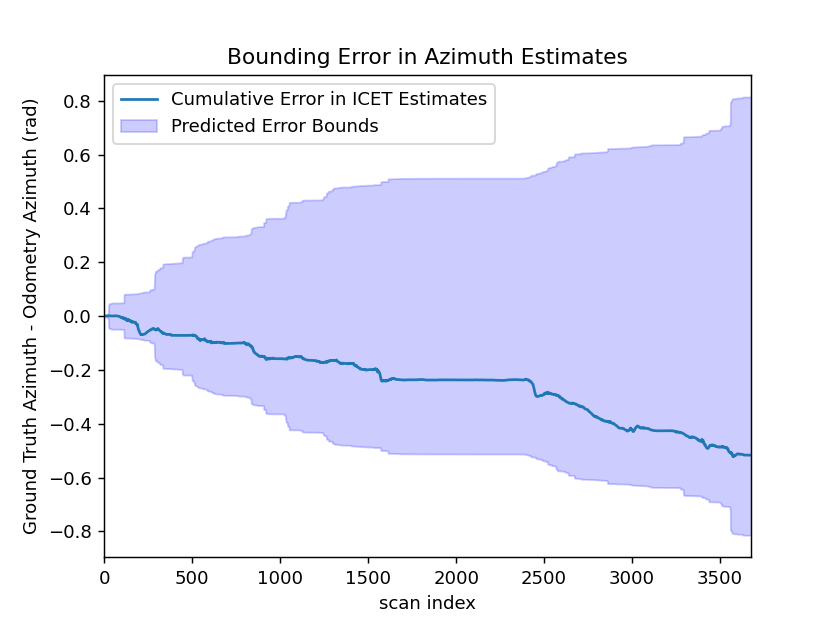

(3809, 6)
(3680, 6)
3809


(0.0, 3678.0)

In [332]:
#plot error between ICET and absolute position
plt.rc('font',family='Times New Roman')
fig3, ax3 = plt.subplots(1,1)
font = {'fontname':'Times New Roman'}

# print(len(estimates), len(ground_truth), len(pred_stds))



# diffx = ground_truth[:len(estimates), 5] - estimates[:,5] #was this

#test
# yaw_gt = (ground_truth[(start_idx+1):(start_idx+runlen+1),5] + ground_truth[start_idx:(start_idx+runlen),5])/2 #works best(?)
yaw_gt = (ground_truth[(start_idx+2):(start_idx+runlen+2),5] + ground_truth[(start_idx+1):(start_idx+runlen+1),5])/2 #works best(?)
# diffx = yaw_gt[:len(estimates)] - estimates[:len(yaw_gt),5]
diffx = (yaw_gt[:len(estimates)]/0.999) - estimates[:len(yaw_gt),5] #need to rescale time estimates


# diffx_LOAM = vf - LOAM[len(vf),1]

cum_err = np.zeros(np.shape(estimates))
cum_diffx = np.zeros(len(estimates))

for i in range(np.shape(estimates)[0]):
    #include sensor noise calculated by ICET 
    cum_err[i,:] = 2*np.sum(pred_stds[:i,:]**2, axis = 0)
    #add in distortion bounds
    cum_err[i,:] += np.sum(m_hat_history[:i,:]**2, axis = 0)
    #add in baseline OXTS 1-sigma errors
    cum_err[i,:] += np.sqrt(2)*np.array([0.05,0.05,0.1,0.0005,0.0005,0.001])**2
#     cum_err[i,:] += np.sqrt(2)*np.array([0.08,0.08,0.1,0.0005,0.0005,0.001745])**2
    cum_err[i,:] = np.sqrt(cum_err[i,:]) 
    
for j in range(np.shape(diffx)[0]):
    cum_diffx[j] = np.sum(diffx[:j]) 

print(np.shape(estimates))
print(np.shape(m_hat_history[0:len(estimates),:]))
print(len(np.linspace(0,len(estimates)-1,len(estimates))))
    
# # error for each individual timestep --------------------------------
# ax3.plot(diffx, label = 'GPS/INS - ICET')
# # ax3.fill_between(np.linspace(0,len(pred_stds)-1,len(pred_stds)), -2*pred_stds[:,c], 2*pred_stds[:,c], 
# #                  color = (0.5,0.5,0.5,0.4), label = 'ICET Predicted 2σ Error Bounds')
# ax3.fill_between(np.linspace(0,len(estimates)-1,len(m_hat_history)), 
#                  -m_hat_history[:len(estimates),0]  - 2*pred_stds[:len(estimates),5], 
#                   m_hat_history[:len(estimates),0] + 2*pred_stds[:len(estimates),5], 
#                  color = (0.5,0.5,0.5,0.4), label = 'Predicted Error Bounds')
# #-------------------------------------------------------------------

# #new (accumulated differences in error)--------------------------
# ax3.plot(np.linspace(0,15,np.shape(ICET_pred_stds)[0]), cum_diffx_with_ground, label = 'GPS/INS - ICET')
ax3.plot(np.linspace(0,len(estimates)-1,len(estimates)), cum_diffx, label = 'Cumulative Error in ICET Estimates')
ax3.fill_between(np.linspace(0,len(estimates)-1,len(estimates)), 
                 -cum_err[:,5], 
                 cum_err[:,5], 
                 color = (0,0,1,0.2), label = 'Predicted Error Bounds')
# # --------------------------------------------------------------------

ax3.legend(loc = 'upper left')
ax3.set_title("Bounding Error in Azimuth Estimates")
ax3.set_xlabel("scan index", **font)
ax3.set_ylabel("Ground Truth Azimuth - Odometry Azimuth (rad)", **font)
ax3.set_xlim([0,3678])

### Debug timestamps from Ford Dataset

(3060, 4)


<IPython.core.display.Javascript object>


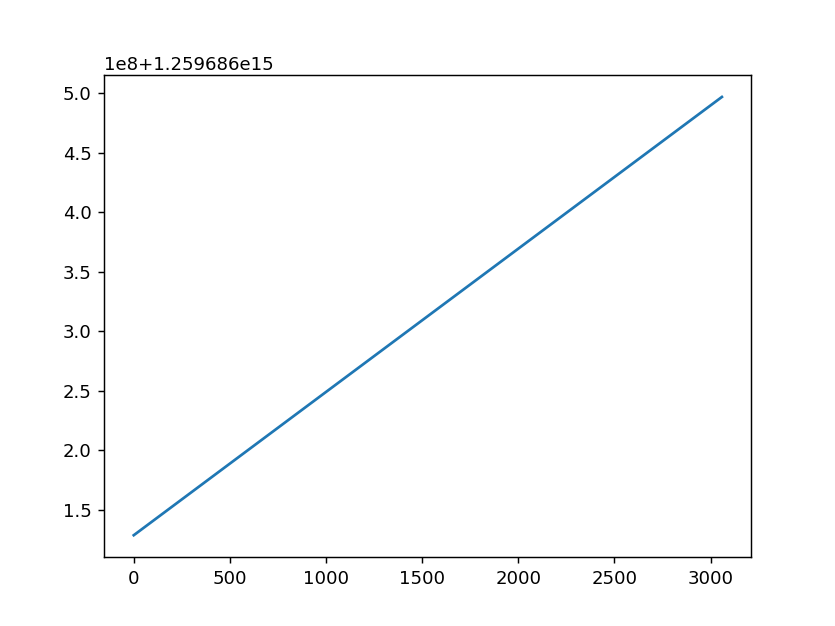

In [302]:
# [framecount, curr_timestamp_sync, curr_timestamp_dc1394,  curr_timestamp_hosttime]
ts_fn = "/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/Timestamp.log"
ts = np.loadtxt(ts_fn, skiprows=1)
# print(ts)

print(np.shape(ts))

fig, ax = plt.subplots()
# ax.plot(np.diff(ts[:,1]))
ax.plot(ts[:,1])
# ax.plot(np.convolve(np.diff(ts[:,1]), np.ones(3)/3, mode='valid'))

In [ ]:
# ### DEBUG: run distortion correction just on "static" point clouds -- not helpful
# it = ICET(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 10, 
#            draw = True, group = 2, RM = True, DNN_filter = False)
# ViewInteractiveWidget(it.plt.window)
# pc1_static = it.cloud1_static
# pc2_static = it.cloud2_static

# plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
# disp=[]
# disp.append(Points(pc1_static, c = "#CB2314")) 
# disp.append(Points(pc2_static, c = "#2c7c94")) 
# plt.show(disp, "raw point clouds")
# ViewInteractiveWidget(plt.window)

In [ ]:
print(np.mean(abs(pred_stds),axis = 0))
print(np.mean(m_hat_history, axis = 0))


In [315]:
a = dat1['SCAN']
print(a.keys())
print(a['timestamp_laser'])

dict_keys(['XYZ', 'timestamp_laser', 'timestamp_camera', 'image_index', 'X_wv', 'Cam'])
1259686252702414.0


In [322]:
start_idx = 2500 #990 #start on this scan
runlen = 100 #3680 #250

ts_history = np.zeros(runlen)

for i in range(runlen):
    print("---------------------------------- SCAN IDX", i + start_idx,"-------------------------------------")

    #load point clouds
    fn1 = '/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/Scan%04d.mat' %(i+start_idx+75)
    dat1 = mat4py.loadmat(fn1)
    SCAN1 = dat1['SCAN']

    ts_history[i] = SCAN1['timestamp_laser']

---------------------------------- SCAN IDX 2500 -------------------------------------
---------------------------------- SCAN IDX 2501 -------------------------------------
---------------------------------- SCAN IDX 2502 -------------------------------------
---------------------------------- SCAN IDX 2503 -------------------------------------
---------------------------------- SCAN IDX 2504 -------------------------------------
---------------------------------- SCAN IDX 2505 -------------------------------------
---------------------------------- SCAN IDX 2506 -------------------------------------
---------------------------------- SCAN IDX 2507 -------------------------------------
---------------------------------- SCAN IDX 2508 -------------------------------------
---------------------------------- SCAN IDX 2509 -------------------------------------
---------------------------------- SCAN IDX 2510 -------------------------------------
---------------------------------- SCAN IDX

---------------------------------- SCAN IDX 2595 -------------------------------------
---------------------------------- SCAN IDX 2596 -------------------------------------
---------------------------------- SCAN IDX 2597 -------------------------------------
---------------------------------- SCAN IDX 2598 -------------------------------------
---------------------------------- SCAN IDX 2599 -------------------------------------


99919.148989899


<IPython.core.display.Javascript object>


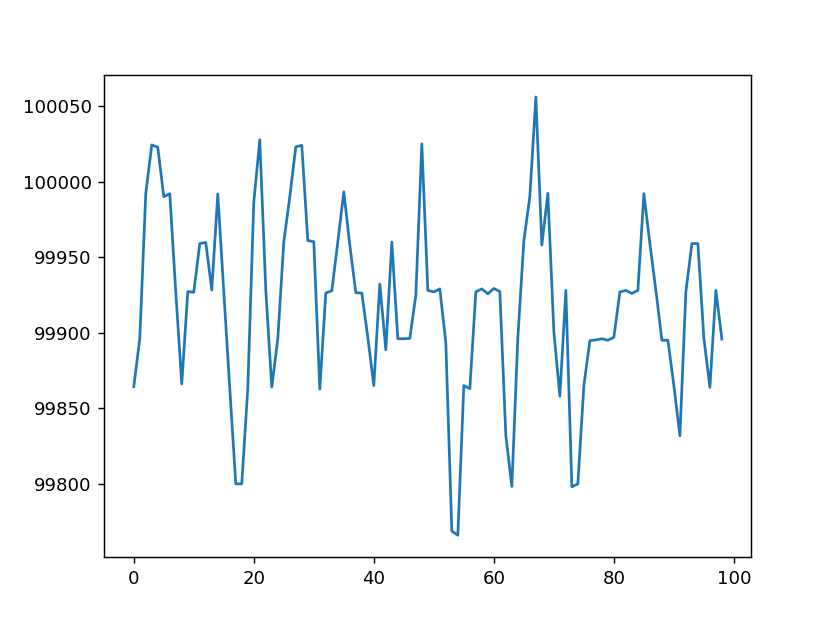

In [335]:
print(np.mean(np.diff(ts_history)))
fig, ax = plt.subplots()
ax.plot(np.diff(ts_history))